In [1]:
## CCSM4 annual OBS

import xarray as xr
sys.path.append("/glade/work/zilumeng/SSNLIM/")
from EOF import EOF
import pickle
import numpy as np

In [2]:
import cfr
job = cfr.ReconJob()
job.proxydb = cfr.ProxyDatabase().fetch("PAGES2kv2")

In [3]:
job.proxydb = job.proxydb.slice([700,2100])
job.annualize_proxydb(months=[12,1,2,3,4,5,6,7,8,9,10,11])


Annualizing ProxyDatabase: 100%|██████████| 692/692 [01:12<00:00,  9.48it/s]


(<Figure size 1000x1000 with 2 Axes>,
 {'map': <GeoAxes: >,
  'count': <Axes: xlabel='Year (AD)', ylabel='number of proxies'>})

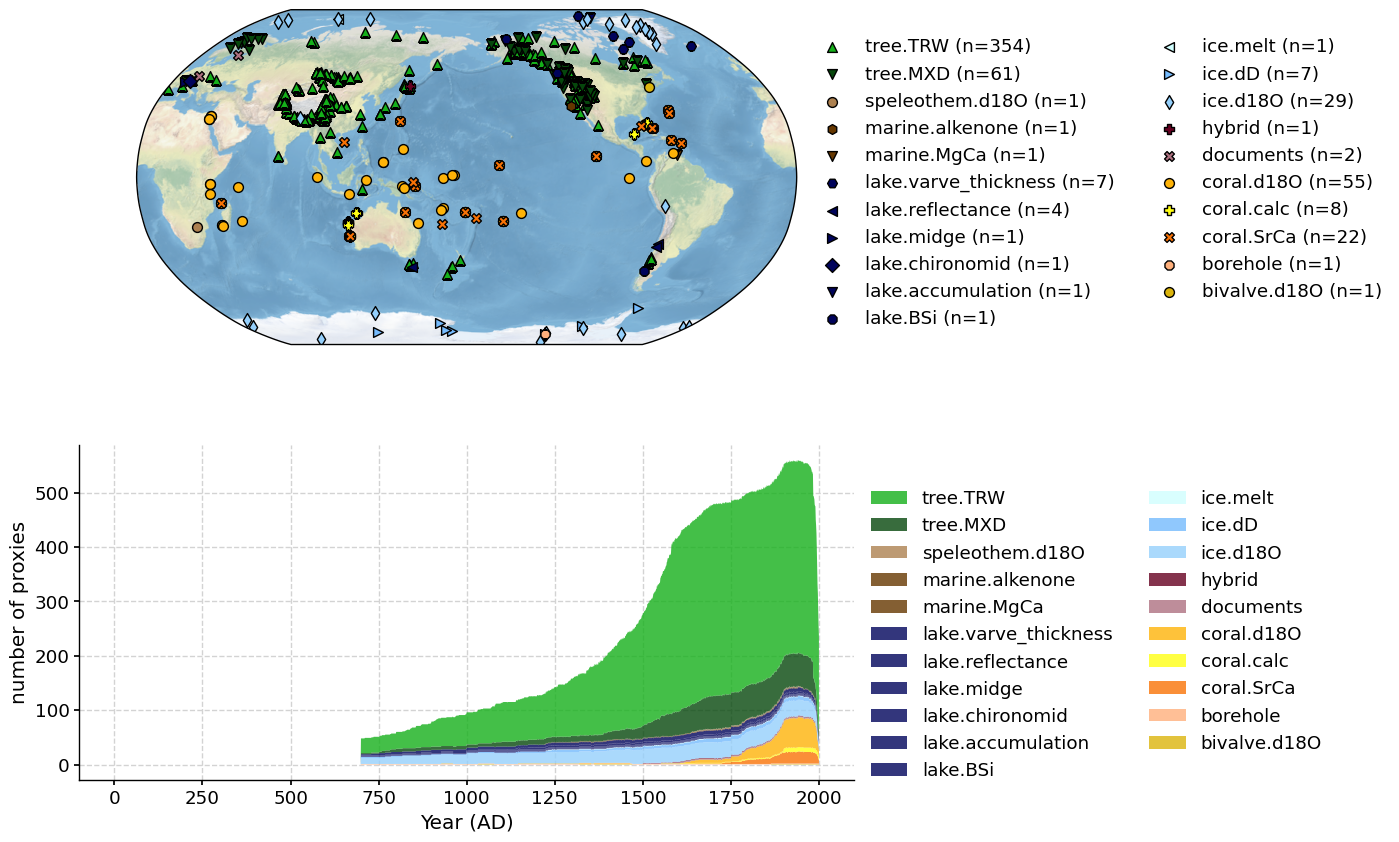

In [63]:
# count 1850 ~ 2000 number
records_l20 = {}
for pname,proxy in job.proxydb.records.items(): 
    time_p = proxy.time
    l1850_tm = time_p[time_p>=1850]
    if len(l1850_tm) >= 80:
        records_l20[pname] = proxy
new_pdb = cfr.ProxyDatabase(records_l20)
new_pdb.plot(plot_count=True)

## Chunck t2m

In [5]:
tas_eof = pickle.load(open('/glade/derecho/scratch/zilumeng/CMIP_LM/CCSM4/season_eof1/tas.pkl', 'rb'))
da_remp = xr.open_dataset("/glade/derecho/scratch/zilumeng/CMIP_LM/OBS/origin/Land_and_Ocean_LatLong_1.2x2.nc")['temperature']
da_remp_anom = da_remp.groupby('time.month') - \
    da_remp.loc['1951':'1980'].groupby('time.month').mean('time')

In [6]:
da_remp_anom.coords

Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2024-05-01
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 7 8 9 10 11 12 1 2 3 4 5

In [7]:
da_remp_anom_fill0 = da_remp_anom.fillna(0)
gis_pc = tas_eof.projection1(da_remp_anom_fill0.to_numpy(),npt=15,time_dims=1)
reconstructed = tas_eof.decoder1(gis_pc)
reconstructed_da = xr.DataArray(reconstructed.real, coords=[da_remp_anom_fill0.time, da_remp_anom_fill0.lat, da_remp_anom_fill0.lon], dims=['time', 'lat', 'lon'])
reconstructed_da = xr.where(~ np.isnan(da_remp_anom), reconstructed_da, np.nan)
reconstructed_ds = xr.Dataset({'temperature': reconstructed_da})
reconstructed_ds.to_netcdf('bekerlyEarth_2x2.15PC_CCSM4_masked.nc')

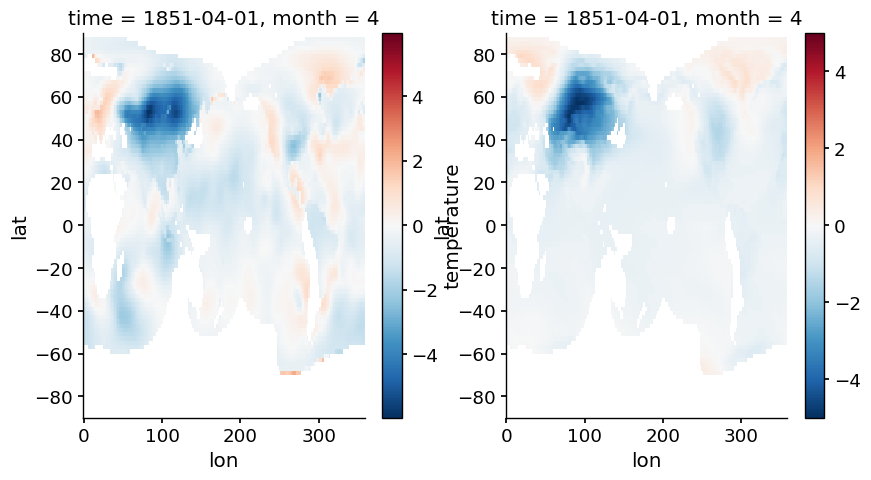

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
idx = 15
da_remp_anom[idx].plot(ax=ax1)
ax2 = fig.add_subplot(122)
reconstructed_da[idx].plot(ax=ax2)

# chunk the tos

In [3]:
tos_eof = pickle.load(open('/glade/derecho/scratch/zilumeng/CMIP_LM/CCSM4/season_eof1/tos.pkl', 'rb'))
da_remp = xr.open_dataset("/glade/derecho/scratch/zilumeng/CMIP_LM/OBS/origin/Land_and_Ocean_LatLong_1.2x2.nc")['temperature']
da_remp_anom = da_remp.groupby('time.month') - \
    da_remp.loc['1951':'1980'].groupby('time.month').mean('time')

In [5]:
da_remp_anom_fill0 = da_remp_anom.fillna(0)
gis_pc = tos_eof.projection1(da_remp_anom_fill0.to_numpy(),npt=15,time_dims=1)
reconstructed = tos_eof.decoder1(gis_pc)
reconstructed_da = xr.DataArray(reconstructed.real, coords=[da_remp_anom_fill0.time, da_remp_anom_fill0.lat, da_remp_anom_fill0.lon], dims=['time', 'lat', 'lon'])
reconstructed_da = xr.where(~ np.isnan(da_remp_anom), reconstructed_da, np.nan)
reconstructed_ds = xr.Dataset({'temperature': reconstructed_da})

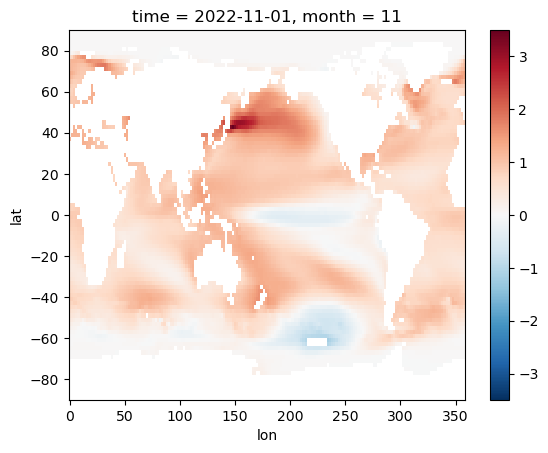

In [8]:
reconstructed_da[-19].plot()

In [9]:
reconstructed_ds.to_netcdf('bekerlyEarth_2x2.15PC_CCSM4_masked_tos.nc')

## Calibrate the model

In [9]:
# seasons = []
seasons = [[-12,1,2],[3,4,5],[6,7,8],[9,10,11]]
seasons += [[-12,1,2,3,4,5],[6,7,8,9,10,11],[3,4,5,6,7,8],]
seasons += [[-12,1,2,3,4,5,6,7,8], [3,4,5,6,7,8,9,10,11],]
            # [-6,-7,-8,-9,-10,-11,-12,1,2],[-9,-10,-11,-12,1,2,3,4,5]]
seasons += [[-12,1,2,3,4,5,6,7,8,9,10,11]] 
for season in seasons:
    print(season,len(season),season[-2])

[-12, 1, 2] 3 1
[3, 4, 5] 3 4
[6, 7, 8] 3 7
[9, 10, 11] 3 10
[-12, 1, 2, 3, 4, 5] 6 4
[6, 7, 8, 9, 10, 11] 6 10
[3, 4, 5, 6, 7, 8] 6 7
[-12, 1, 2, 3, 4, 5, 6, 7, 8] 9 7
[3, 4, 5, 6, 7, 8, 9, 10, 11] 9 10
[-12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] 12 10


In [10]:
pdb_noocean = new_pdb
job_noocean = cfr.ReconJob()
job_noocean.proxydb = pdb_noocean
job_noocean.load_clim(
    tag='obs',
    path_dict={
        'tas': '/glade/u/home/zilumeng/SI_recon/OBS/ann_obs/bekerlyEarth_2x2.15PC_CCSM4_nomask.nc',
    },
    rename_dict={'tas': 'temperature'},
    anom_period=(1951, 1980), # 1951-1980 is the reference period for GISTEMP
    verbose=True,
)
job_noocean.annualize_proxydb(months=[12,1,2,3,4,5,6,7,8,9,10,11])
ptype_season_dict = {}
ptype_psm_dict = {}
ptype_obs_dict = {}
for ptype in job_noocean.proxydb.type_dict.keys():
    ptype_season_dict[ptype] = seasons
    ptype_psm_dict[ptype] = 'Linear'
    ptype_obs_dict[ptype] = ['tas']
job_noocean.calib_psms(ptype_psm_dict=ptype_psm_dict,ptype_season_dict=ptype_season_dict,calib_period=(1850, 2015),
    verbose=True,ptype_clim_dict=ptype_obs_dict)

>>> job.configs["obs_path"] = {'tas': '/glade/u/home/zilumeng/SI_recon/OBS/ann_obs/bekerlyEarth_2x2.15PC_CCSM4_nomask.nc'}
>>> job.configs["obs_rename_dict"] = {'tas': 'temperature'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> obs variables ['tas'] loaded
>>> job.obs created


Annualizing ProxyDatabase: 100%|██████████| 560/560 [01:03<00:00,  8.76it/s]


>>> job.configs["ptype_psm_dict"] = {'documents': 'Linear', 'lake.reflectance': 'Linear', 'marine.alkenone': 'Linear', 'hybrid': 'Linear', 'speleothem.d18O': 'Linear', 'ice.dD': 'Linear', 'coral.d18O': 'Linear', 'marine.MgCa': 'Linear', 'lake.varve_thickness': 'Linear', 'ice.melt': 'Linear', 'bivalve.d18O': 'Linear', 'tree.MXD': 'Linear', 'coral.SrCa': 'Linear', 'borehole': 'Linear', 'lake.accumulation': 'Linear', 'lake.BSi': 'Linear', 'coral.calc': 'Linear', 'tree.TRW': 'Linear', 'ice.d18O': 'Linear', 'lake.midge': 'Linear', 'lake.chironomid': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'documents': [[-12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [-12, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [3, 4, 5, 6, 7, 8], [-12, 1, 2, 3, 4, 5, 6, 7, 8], [3, 4, 5, 6, 7, 8, 9, 10, 11], [-12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], 'lake.reflectance': [[-12, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [-12, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11], [3, 4, 5, 6, 7, 8], [-12, 1, 2, 3, 4, 5, 6, 7, 8], [3, 

Calibrating the PSMs: 100%|██████████| 560/560 [03:49<00:00,  2.44it/s]

>>> 560 records tagged "calibrated" with ProxyRecord.psm created


(<Figure size 1000x1000 with 2 Axes>,
 {'map': <GeoAxes: >,
  'count': <Axes: xlabel='Year (AD)', ylabel='number of proxies'>})

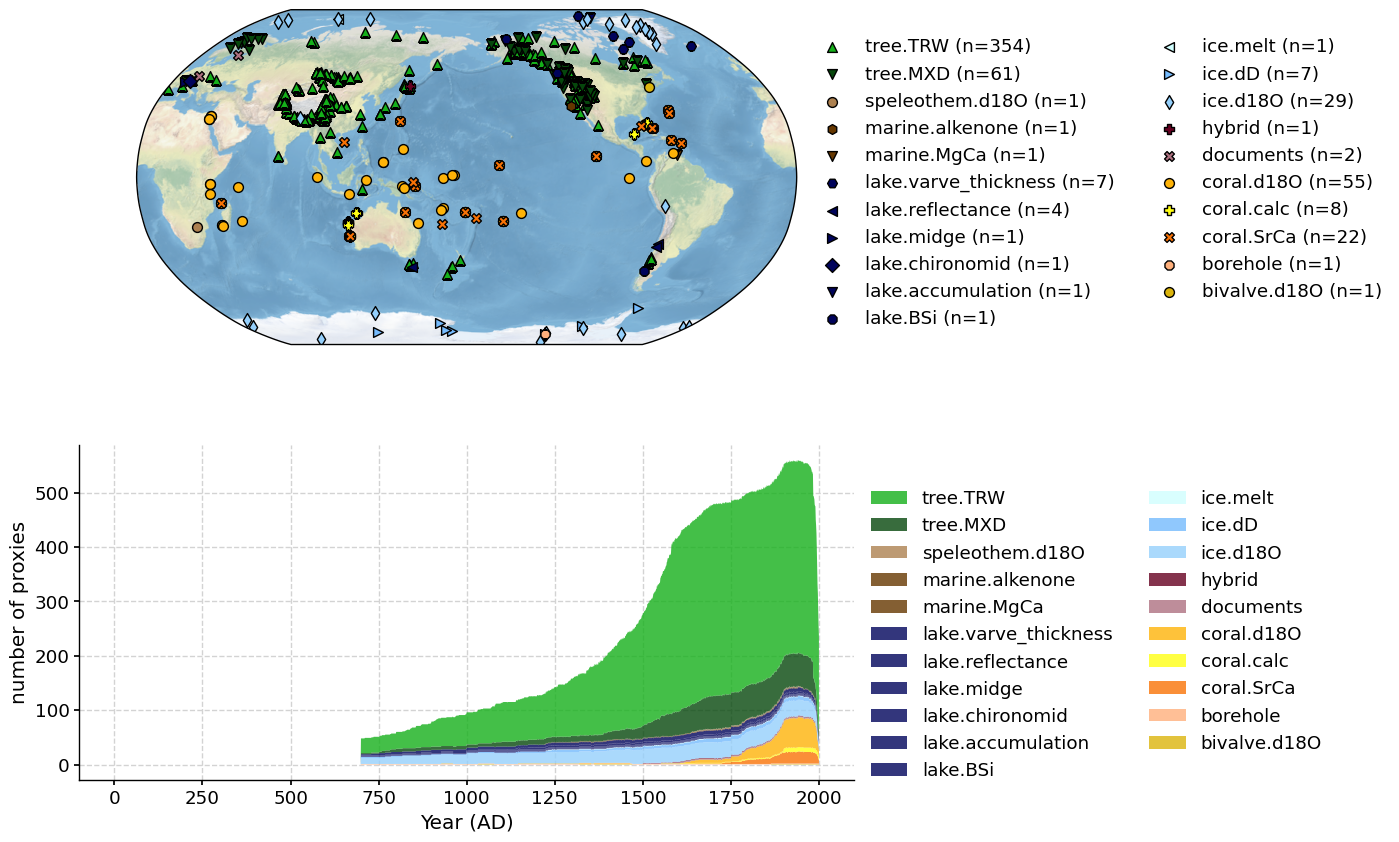

In [11]:
job_all = cfr.ReconJob()
job_all.proxydb = job_noocean.proxydb
job_all.proxydb.filter(by='tag',keys={"calibrated"}).plot(plot_count=True)
# job_all.save('./data/CCSM15PC_annual.pkl')


In [13]:
# calculate cov matrix:

pdb = job_all.proxydb
from tqdm import tqdm
nproxy = len(pdb.records)
error_matrix = np.zeros((nproxy, nproxy))
corr_matrix = np.zeros((nproxy, nproxy))
for i, (pname, proxy) in tqdm(enumerate(pdb.records.items()), total=nproxy):
    calib_resi = proxy.psm.calib_details['PSMresid']
    for j, (pname2, proxy2) in enumerate(pdb.records.items()):
        calib_resi2= proxy2.psm.calib_details['PSMresid']
        time_cov = calib_resi.index.intersection(calib_resi2.index)
        resi_inter = calib_resi.loc[time_cov]
        resi_inter2 = calib_resi2.loc[time_cov]
        error_matrix[i,j] = np.dot(resi_inter-resi_inter.mean(),resi_inter2 - resi_inter2.mean()) / len(time_cov)
        corr_matrix[i,j] = error_matrix[i,j] / resi_inter.std() / resi_inter2.std()
        if np.isnan(error_matrix[i,j]):
            print(pname,pname2)
        

100%|██████████| 560/560 [03:53<00:00,  2.40it/s]


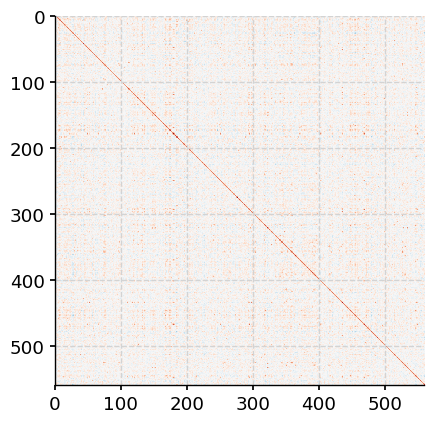

In [14]:
plt.imshow(corr_matrix,vmin=-1,vmax=1,cmap='RdBu_r')
# plt.colorbar()

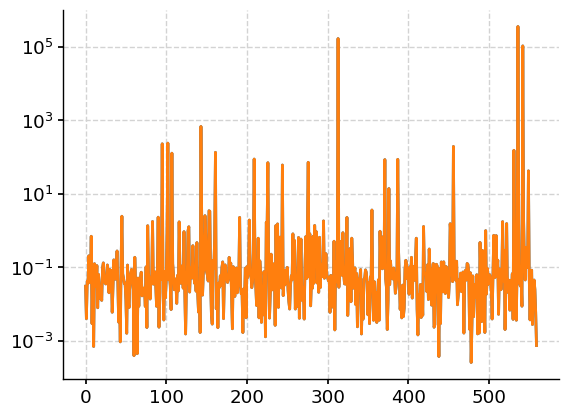

In [15]:
# plt.imshow(np.isnan(error_matrix
plt.plot(np.diag(error_matrix))
plt.plot([proxy.R for idx,(pname2, proxy) in enumerate(pdb.records.items())])
plt.yscale("log")
# plt.scale("log")

In [16]:
import pandas as pd

colomn = [pname for pname,proxy in pdb.records.items()]

job_all.save('./data/CCSM15PC_annual_berkeleyEar_error_matrix.pkl')
error_frame = pd.DataFrame(error_matrix, index=colomn, columns=colomn)
error_frame.to_pickle('./data/CCSM15PC_annual_berkeleyEar_error_matrix.pkl/error_matrix.pkl')
error_frame.head()

,NAm_153,NAm_165,Asi_178,Asi_174,Eur_016,Asi_198,NAm_145,Arc_071,NAm_102,NAm_046,...,Asi_227,NAm_143,Asi_208,Asi_119,Ocn_153,Asi_026,Asi_201,Asi_179,Ocn_071,Ocn_072
NAm_153,0.030966,0.000355,0.006672,0.000692,0.004026,0.005000,0.010792,0.036816,0.000641,0.001543,...,0.001392,0.000600,-0.004911,-0.009972,-0.002577,0.000500,-0.001272,-0.000829,-0.000406,-0.000179
NAm_165,0.000355,0.004069,-0.000233,-0.000162,-0.004656,0.001078,-0.000297,0.011597,-0.000258,0.000568,...,0.001039,0.000668,-0.001963,-0.000426,-0.000175,0.000086,0.001436,0.002488,-0.000781,0.000306
Asi_178,0.006672,-0.000233,0.042045,0.002347,0.010436,0.000736,-0.006951,0.019041,-0.000294,0.002874,...,-0.010263,-0.000835,0.006574,0.000979,-0.000489,0.004142,0.000501,0.009468,0.003733,0.001113
Asi_174,0.000692,-0.000162,0.002347,0.037157,0.015194,0.005214,0.006751,-0.015252,0.002210,-0.005923,...,0.001457,-0.000153,0.003918,0.000085,-0.002221,0.006176,0.006023,0.007759,0.000250,-0.000309
Eur_016,0.004026,-0.004656,0.010436,0.015194,0.207360,0.007684,0.016271,-0.019427,0.004126,-0.023734,...,-0.007642,-0.008398,0.013597,0.017036,-0.008249,-0.002110,-0.004265,0.003777,0.002524,-0.004434


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
error_frame = pd.read_pickle('./data/CCSM15PC_annual_berkeleyEar_error_matrix.pkl/error_matrix.pkl').to_numpy()
np.max(np.abs(error_frame.T - error_frame))

0.0

array([-2.84800906e-01, -1.64468716e-01, -1.46340005e-01, -1.36711027e-01,
       -1.06547614e-01, -9.37922848e-02, -7.75452304e-02, -6.09479492e-02,
       -5.11987349e-02, -4.67410655e-02, -3.68149916e-02, -3.47271494e-02,
       -3.21343829e-02, -2.65425989e-02, -2.43380671e-02, -2.19188388e-02,
       -1.95888727e-02, -1.87188048e-02, -1.74693233e-02, -1.58282702e-02,
       -1.52461179e-02, -1.45739499e-02, -1.40837107e-02, -1.31943389e-02,
       -1.24053632e-02, -1.22405622e-02, -1.21546734e-02, -1.13908833e-02,
       -1.12266541e-02, -1.06288642e-02, -1.01086005e-02, -9.83364905e-03,
       -9.57364461e-03, -9.37098154e-03, -9.00713278e-03, -8.24968423e-03,
       -8.19964054e-03, -8.08375797e-03, -8.06036379e-03, -7.99541753e-03,
       -7.69282594e-03, -7.25907100e-03, -7.16828507e-03, -6.80226522e-03,
       -6.69091863e-03, -6.47437214e-03, -6.35882681e-03, -6.26707522e-03,
       -6.02873234e-03, -5.86102225e-03, -5.81253175e-03, -5.67856806e-03,
       -5.51219321e-03, -

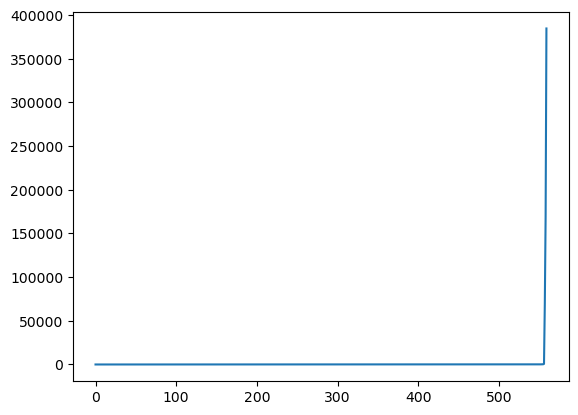

In [11]:
lamb, E = np.linalg.eigh(error_frame)
plt.plot(lamb)
lamb[lamb < 0]

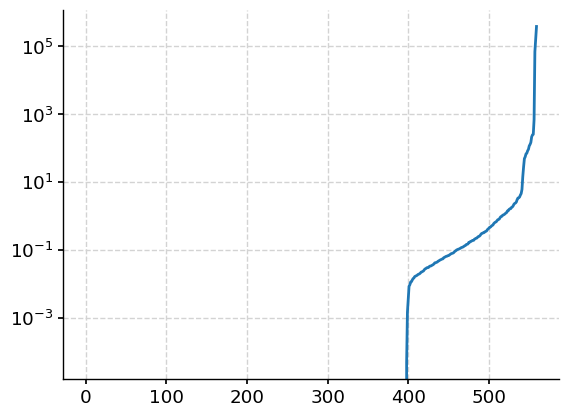

In [58]:
# error_frame.max()
lamb, E = np.linalg.eigh(error_matrix[:990,:990])
# np.min(lamb)
plt.plot(lamb)
plt.yscale('log')

In [60]:
len(lamb[lamb<0])

398

In [45]:
# E[:,-1] - E[-1
np.min(lamb),

(-0.2848009063540104,)

In [17]:
all_dict = {}
pdb = job_all.proxydb.filter(by='tag',keys={"calibrated"})
for ptype in pdb.type_dict.keys():
    ptype_pdb = pdb.filter(by='ptype',keys={ptype})
    p_season_dict = {}
    for season in seasons:
        p_season_dict[str(season)] = 0 
    for pid, proxy in ptype_pdb.records.items():
        pseason = str(proxy.psm.calib_details['seasonality'])
        if p_season_dict.get(pseason) == None:
            p_season_dict[pseason] = 1
        else:
            p_season_dict[pseason] += 1
    all_dict[ptype] = p_season_dict

/glade/derecho/scratch/zilumeng/tmp/ipykernel_70113/920239405.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=90)
/glade/derecho/scratch/zilumeng/tmp/ipykernel_70113/920239405.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=90)
/glade/derecho/scratch/zilumeng/tmp/ipykernel_70113/920239405.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=90)
/glade/derecho/scratch/zilumeng/tmp/ipykernel_70113/920239405.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x, rotation=90)
/glade/derecho/scratch/zilumeng/tmp/ipykernel_70113/920239405.py

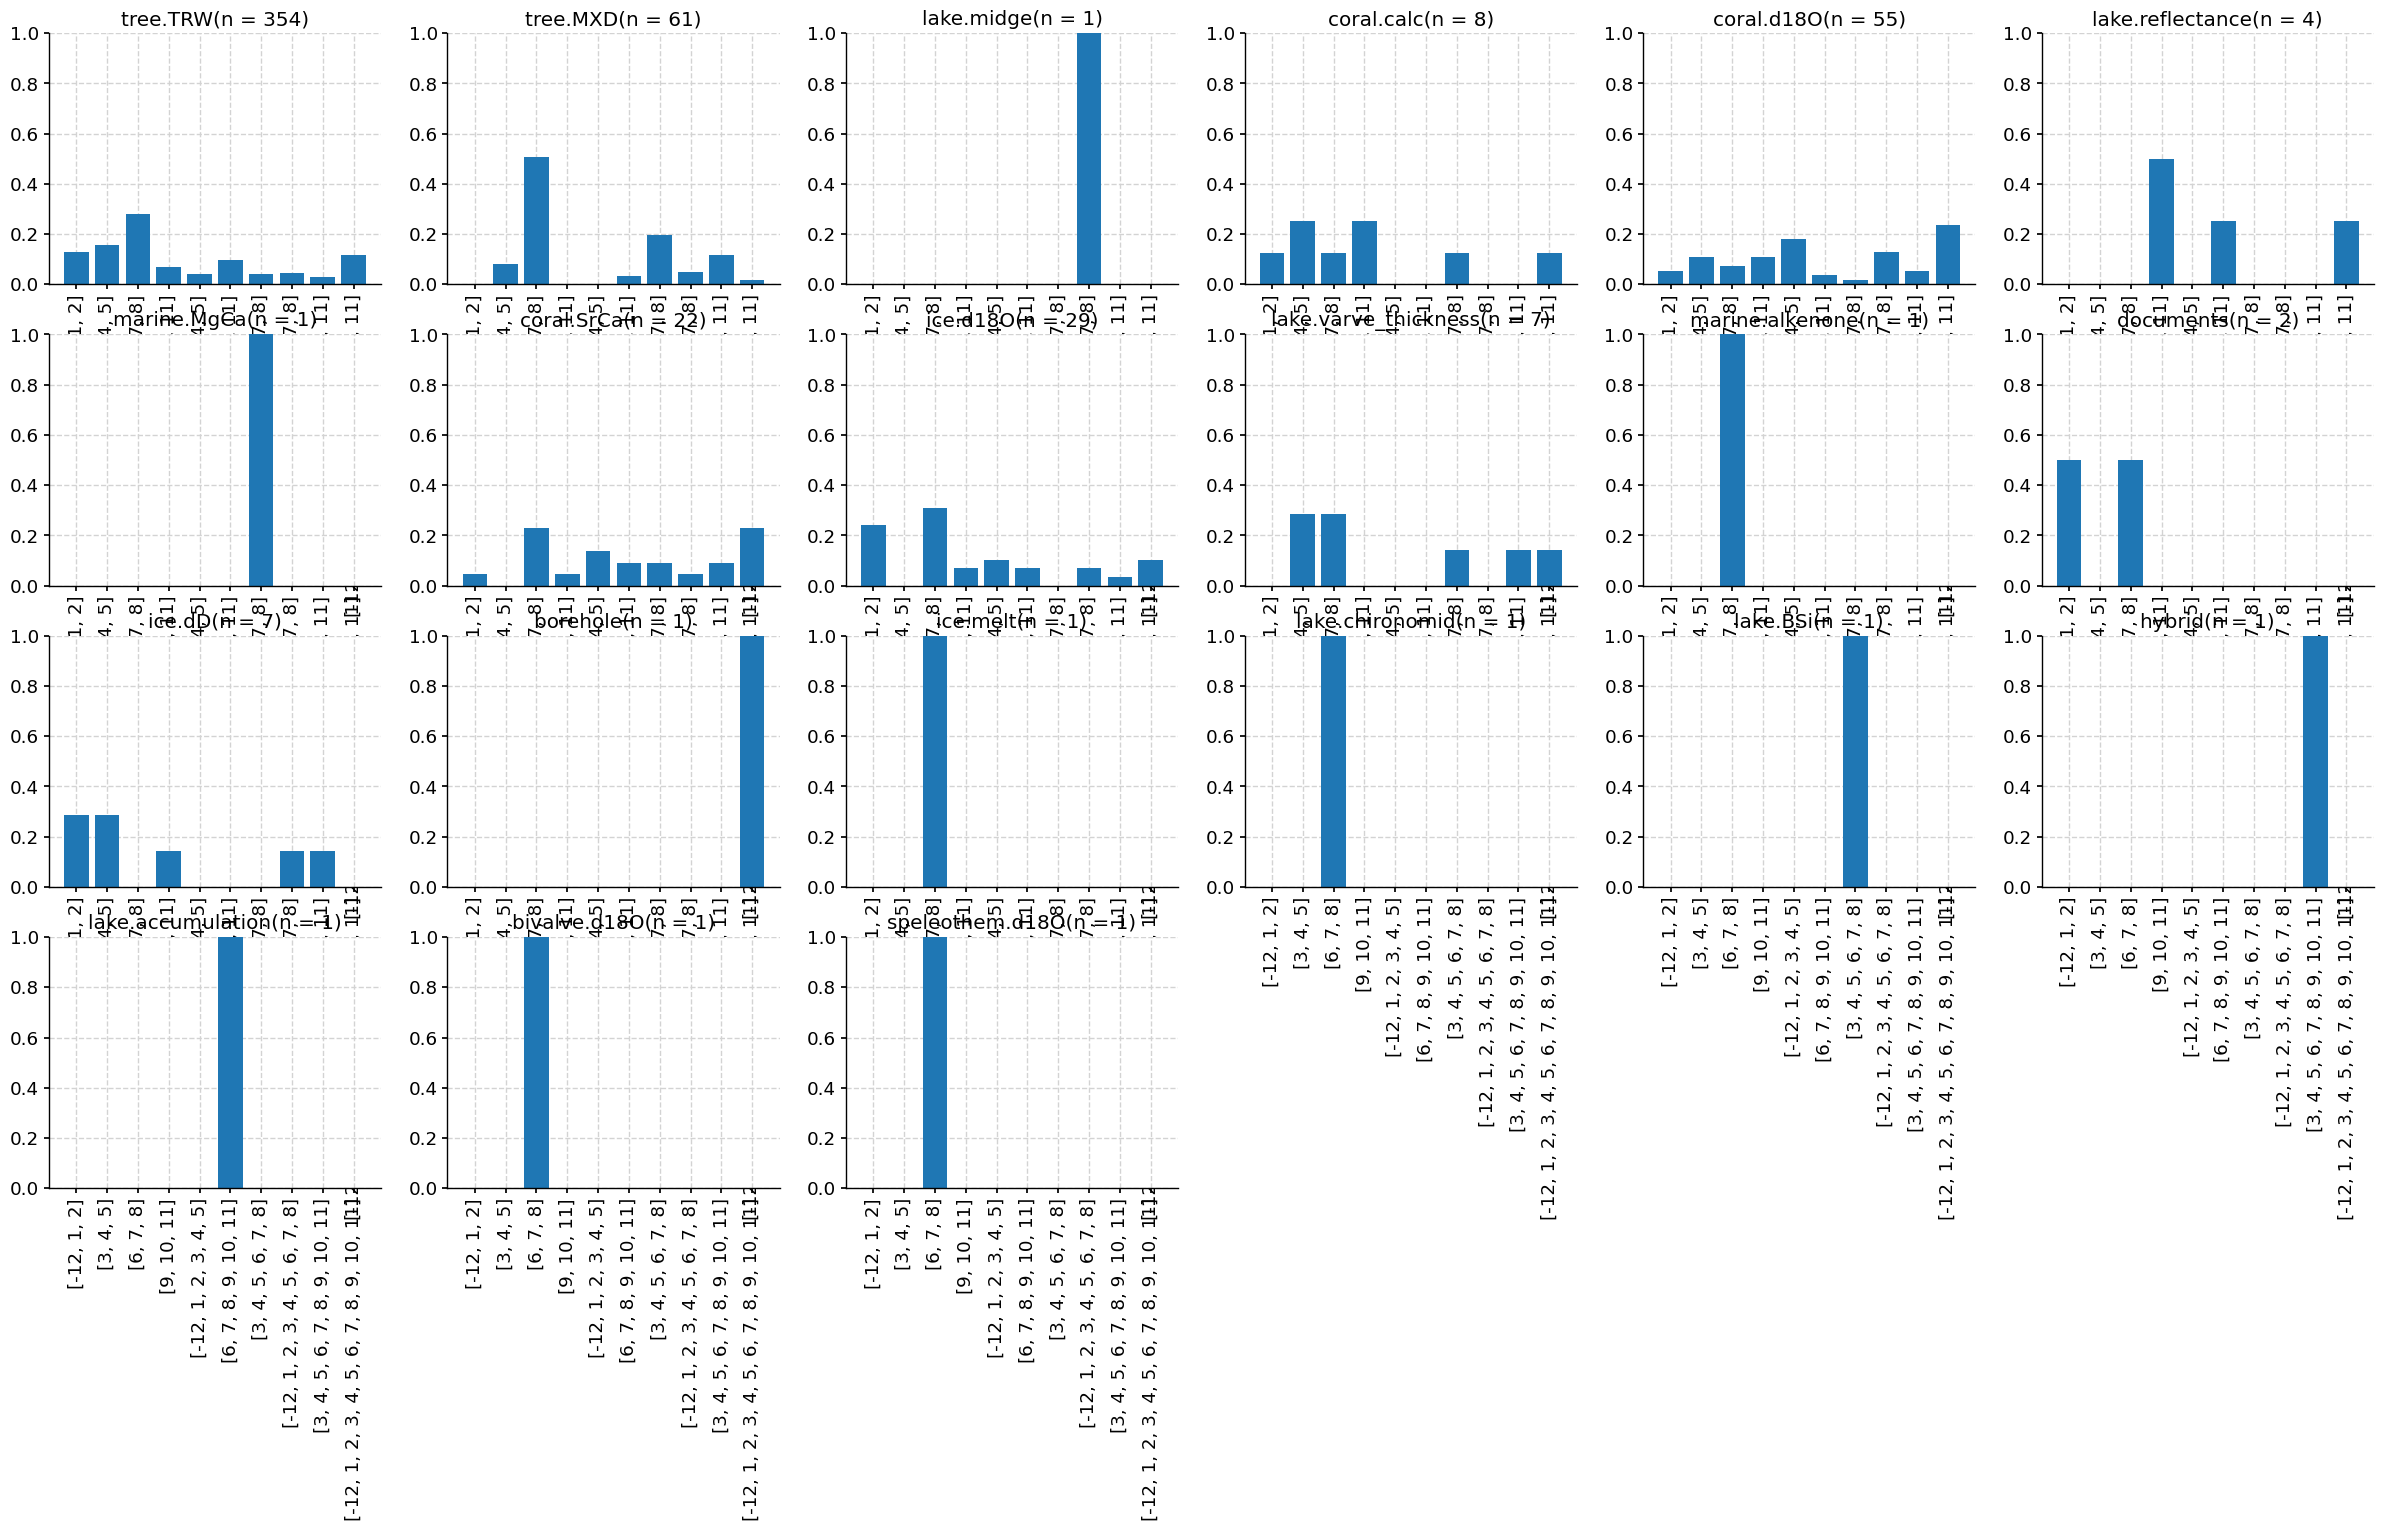

In [18]:
import matplotlib.pyplot as plt

x = [str(sn) for sn in seasons]
# sn_name = ['DJF','MAM','JJA','SON','SONDJF','DJFMAM','JJASON','MAMJASON','ANN']
fig = plt.figure(figsize=(30,15))

for i, ptype in enumerate(all_dict.keys()):
    ax = fig.add_subplot(4,6,i+1)
    y = [all_dict[ptype][sn] for sn in x]
    num = sum(y)
    ax.bar(x,np.array(y)/num,label=ptype)
    # ax.set_xticklabels(sn_name,rotation=45)
    # ax.legend(loc='upper right',ncol=4)
    ax.set_title(ptype + f"(n = {num})")
    ax.set_xticklabels(x, rotation=90)
    ax.set_ylim(0,1)
plt.tight_layout()